Training DCGAN...


Training: |          | 0/? [00:00<?, ?it/s]

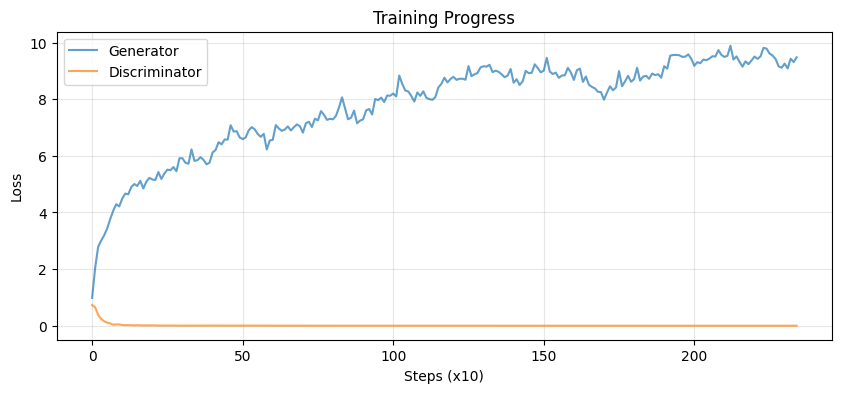

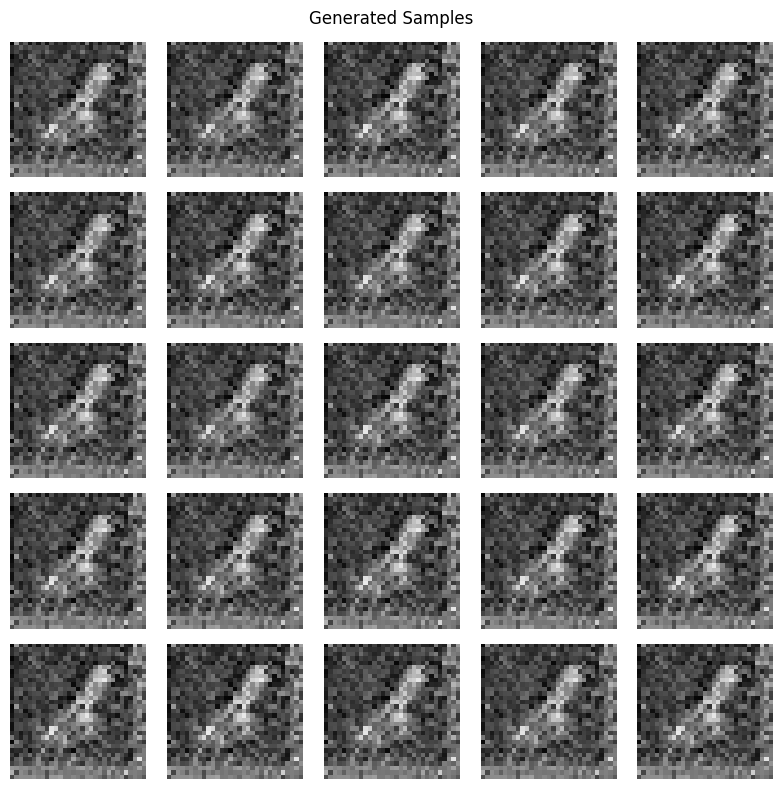

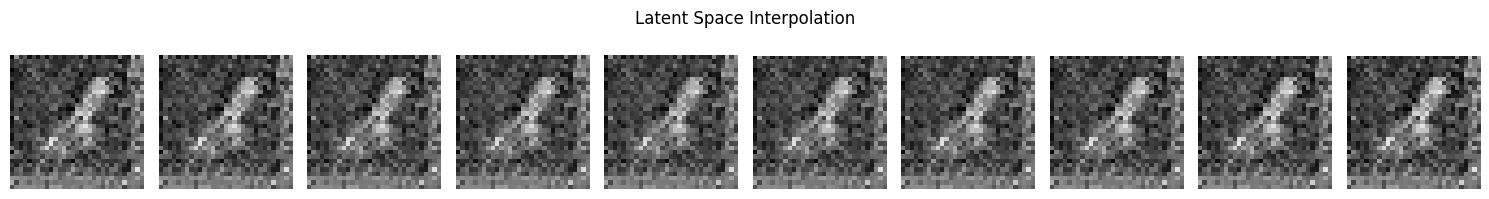

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import TQDMProgressBar
import matplotlib.pyplot as plt
import numpy as np

class Generator(nn.Module):
    def __init__(self, latent_dim=100, feature_maps=64):
        super().__init__()
        
        self.latent_dim = latent_dim
        
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(latent_dim, feature_maps * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_maps * 8),
            nn.ReLU(True),
            # state size: (feature_maps*8) x 4 x 4
            nn.ConvTranspose2d(feature_maps * 8, feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.ReLU(True),
            # state size: (feature_maps*4) x 8 x 8
            nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.ReLU(True),
            # state size: (feature_maps*2) x 16 x 16
            nn.ConvTranspose2d(feature_maps * 2, feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),
            # state size: (feature_maps) x 32 x 32
            nn.Conv2d(feature_maps, 1, 4, 1, 1, bias=False),
            nn.Tanh()
            # state size: 1 x 28 x 28
        )

    def forward(self, z):
        z = z.view(z.size(0), self.latent_dim, 1, 1)
        return self.main(z)

class Discriminator(nn.Module):
    def __init__(self, feature_maps=64):
        super().__init__()
        
        self.main = nn.Sequential(
            # input is 1 x 28 x 28
            nn.Conv2d(1, feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: feature_maps x 14 x 14
            nn.Conv2d(feature_maps, feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (feature_maps * 2) x 7 x 7
            nn.Conv2d(feature_maps * 2, feature_maps * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (feature_maps * 4) x 4 x 4
            nn.Conv2d(feature_maps * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1)

class DCGAN(pl.LightningModule):
    def __init__(
        self,
        latent_dim: int = 100,
        feature_maps_g: int = 64,
        feature_maps_d: int = 64,
        learning_rate: float = 0.0002,
        beta1: float = 0.5,
    ):
        super().__init__()
        self.save_hyperparameters()
        
        # Set manual optimization
        self.automatic_optimization = False
        
        # Networks
        self.generator = Generator(latent_dim, feature_maps_g)
        self.discriminator = Discriminator(feature_maps_d)
        
        # Visualization
        self.register_buffer("fixed_noise", torch.randn(64, latent_dim))
        self.example_input = None
        
        # Tracking
        self.g_losses = []
        self.d_losses = []
        
    def forward(self, z):
        return self.generator(z)
    
    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)
    
    def training_step(self, batch, batch_idx):
        g_opt, d_opt = self.optimizers()
        
        real_imgs, _ = batch
        batch_size = real_imgs.size(0)
        
        # Ground truth labels
        valid = torch.ones(batch_size, device=self.device)
        fake = torch.zeros(batch_size, device=self.device)
        
        # Train Discriminator
        d_opt.zero_grad()
        
        # Real images
        d_output_real = self.discriminator(real_imgs)
        d_real_loss = self.adversarial_loss(d_output_real, valid)
        
        # Fake images
        z = torch.randn(batch_size, self.hparams.latent_dim, device=self.device)
        fake_imgs = self(z)
        d_output_fake = self.discriminator(fake_imgs.detach())
        d_fake_loss = self.adversarial_loss(d_output_fake, fake)
        
        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2
        self.manual_backward(d_loss)
        d_opt.step()
        
        # Train Generator
        g_opt.zero_grad()
        
        # Generate new images
        z = torch.randn(batch_size, self.hparams.latent_dim, device=self.device)
        gen_imgs = self(z)
        
        # Calculate generator loss
        d_output = self.discriminator(gen_imgs)
        g_loss = self.adversarial_loss(d_output, valid)
        
        self.manual_backward(g_loss)
        g_opt.step()
        
        # Logging
        self.g_losses.append(g_loss.item())
        self.d_losses.append(d_loss.item())
        
        self.log_dict({
            "g_loss": g_loss,
            "d_loss": d_loss,
        }, prog_bar=True)
        
        # Generate samples periodically
        if batch_idx % 100 == 0:
            self.generate_samples()
    
    def generate_samples(self):
        """Generate and store sample images"""
        self.eval()
        with torch.no_grad():
            samples = self(self.fixed_noise)
            self.current_samples = samples
        self.train()
    
    def configure_optimizers(self):
        g_opt = optim.Adam(
            self.generator.parameters(), 
            lr=self.hparams.learning_rate,
            betas=(self.hparams.beta1, 0.999)
        )
        d_opt = optim.Adam(
            self.discriminator.parameters(),
            lr=self.hparams.learning_rate,
            betas=(self.hparams.beta1, 0.999)
        )
        return [g_opt, d_opt]

def plot_training_progress(model):
    plt.figure(figsize=(10, 4))
    plt.plot(model.g_losses[::10], label='Generator', alpha=0.7)
    plt.plot(model.d_losses[::10], label='Discriminator', alpha=0.7)
    plt.xlabel('Steps (x10)')
    plt.ylabel('Loss')
    plt.title('Training Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_current_samples(model, num_images=25):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_images, model.hparams.latent_dim, device=model.device)
        samples = model(z).cpu()
    model.train()
    
    fig = plt.figure(figsize=(8, 8))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(samples[i].squeeze(), cmap='gray', vmin=-1, vmax=1)
        plt.axis('off')
    plt.suptitle('Generated Samples')
    plt.tight_layout()
    plt.show()

def interpolate_latent_space(model, num_steps=10):
    model.eval()
    with torch.no_grad():
        z1 = torch.randn(1, model.hparams.latent_dim, device=model.device)
        z2 = torch.randn(1, model.hparams.latent_dim, device=model.device)
        
        alphas = torch.linspace(0, 1, num_steps)
        z_interp = torch.stack([(1-a)*z1 + a*z2 for a in alphas]).squeeze()
        
        interp_images = model(z_interp)
    model.train()
    
    plt.figure(figsize=(15, 2))
    for i in range(num_steps):
        plt.subplot(1, num_steps, i + 1)
        plt.imshow(interp_images[i].cpu().squeeze(), cmap='gray', vmin=-1, vmax=1)
        plt.axis('off')
    plt.suptitle('Latent Space Interpolation')
    plt.tight_layout()
    plt.show()

def train_dcgan():
    # Set random seeds
    pl.seed_everything(42)
    
    # Data loading
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    train_dataset = datasets.MNIST('/kaggle/working/data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
    
    # Model training
    model = DCGAN()
    
    trainer = pl.Trainer(
        max_epochs=5,
        accelerator='auto',
        devices=1,
        callbacks=[TQDMProgressBar(refresh_rate=20)],
    )
    
    print("Training DCGAN...")
    trainer.fit(model, train_loader)
    
    # Visualizations
    plot_training_progress(model)
    plot_current_samples(model)
    interpolate_latent_space(model)
    
    return model

if __name__ == "__main__":
    model = train_dcgan()

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import TQDMProgressBar
import matplotlib.pyplot as plt
import numpy as np

class Generator(nn.Module):
    def __init__(self, latent_dim=100, ngf=64):
        super().__init__()
        self.latent_dim = latent_dim
        
        self.main = nn.Sequential(
            # Input is Z, going into a convolution
            # (nz) x 1 x 1 -> (ngf*8) x 4 x 4
            nn.ConvTranspose2d(latent_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            # (ngf*8) x 4 x 4 -> (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            # (ngf*4) x 8 x 8 -> (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            # (ngf*2) x 16 x 16 -> (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            # (ngf) x 32 x 32 -> (nc) x 32 x 32
            nn.ConvTranspose2d(ngf, 3, 3, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(z.size(0), self.latent_dim, 1, 1)
        return self.main(z)

class Discriminator(nn.Module):
    def __init__(self, ndf=64):
        super().__init__()
        
        self.main = nn.Sequential(
            # Input (nc) x 32 x 32 -> (ndf) x 16 x 16
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # (ndf) x 16 x 16 -> (ndf*2) x 8 x 8
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # (ndf*2) x 8 x 8 -> (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # (ndf*4) x 4 x 4 -> 1
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1)

class DCGAN(pl.LightningModule):
    def __init__(
        self,
        latent_dim: int = 100,
        ngf: int = 64,
        ndf: int = 64,
        lr: float = 0.0002,
        beta1: float = 0.5,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.automatic_optimization = False
        
        # Networks
        self.generator = Generator(latent_dim, ngf)
        self.discriminator = Discriminator(ndf)
        
        # Initialize weights
        self.generator.apply(self._weights_init)
        self.discriminator.apply(self._weights_init)
        
        # Fixed noise for visualization
        self.register_buffer("fixed_noise", torch.randn(64, latent_dim))
        
        # Loss function
        self.criterion = nn.BCELoss()
        
        # Tracking
        self.g_losses = []
        self.d_losses = []
        
    def _weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
    
    def forward(self, z):
        return self.generator(z)
    
    def training_step(self, batch, batch_idx):
        # Get optimizers
        g_opt, d_opt = self.optimizers()
        
        real_imgs, _ = batch
        batch_size = real_imgs.size(0)
        
        # Create labels
        real_label = torch.ones(batch_size, device=self.device)
        fake_label = torch.zeros(batch_size, device=self.device)
        
        ###########################
        # Train Discriminator
        ###########################
        d_opt.zero_grad()
        
        # Train with real
        label = real_label
        output = self.discriminator(real_imgs)
        errD_real = self.criterion(output, label)
        D_x = output.mean().item()
        
        # Train with fake
        noise = torch.randn(batch_size, self.hparams.latent_dim, device=self.device)
        fake = self.generator(noise)
        label = fake_label
        output = self.discriminator(fake.detach())
        errD_fake = self.criterion(output, label)
        D_G_z1 = output.mean().item()
        
        # Add up losses and update D
        errD = errD_real + errD_fake
        self.manual_backward(errD)
        d_opt.step()

        ###########################
        # Train Generator
        ###########################
        g_opt.zero_grad()
        
        label = real_label  # fake labels are real for generator cost
        output = self.discriminator(fake)
        errG = self.criterion(output, label)
        D_G_z2 = output.mean().item()
        
        # Update G
        self.manual_backward(errG)
        g_opt.step()
        
        # Save loss values
        self.g_losses.append(errG.item())
        self.d_losses.append(errD.item())
        
        # Log progress
        if batch_idx % 100 == 0:
            self.log_dict({
                "g_loss": errG.item(),
                "d_loss": errD.item(),
                "D_x": D_x,
                "D_G_z1": D_G_z1,
                "D_G_z2": D_G_z2
            }, prog_bar=True)
            
            # Generate and log sample images
            with torch.no_grad():
                fake = self(self.fixed_noise)
                self.logger.experiment.add_images(
                    "generated_images",
                    (fake + 1) / 2,
                    self.current_epoch
                )
    
    def configure_optimizers(self):
        g_opt = optim.Adam(
            self.generator.parameters(), 
            lr=self.hparams.lr,
            betas=(self.hparams.beta1, 0.999)
        )
        d_opt = optim.Adam(
            self.discriminator.parameters(),
            lr=self.hparams.lr,
            betas=(self.hparams.beta1, 0.999)
        )
        return [g_opt, d_opt]

def train_dcgan():
    """Train DCGAN on CIFAR-10"""
    pl.seed_everything(42)
    
    # Data loading
    transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    
    dataset = datasets.CIFAR10(root='data', train=True, download=True,
                             transform=transform)
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True, 
                          num_workers=2, pin_memory=True)
    
    # Model training
    model = DCGAN()
    
    trainer = pl.Trainer(
        max_epochs=25,
        accelerator='auto',
        devices=1,
        callbacks=[TQDMProgressBar(refresh_rate=20)],
        log_every_n_steps=10
    )
    
    print("Training DCGAN...")
    trainer.fit(model, dataloader)
    
    return model

if __name__ == "__main__":
    model = train_dcgan()

Files already downloaded and verified
Training DCGAN...


Training: |          | 0/? [00:00<?, ?it/s]

Plotting current generated samples (upscaled)...


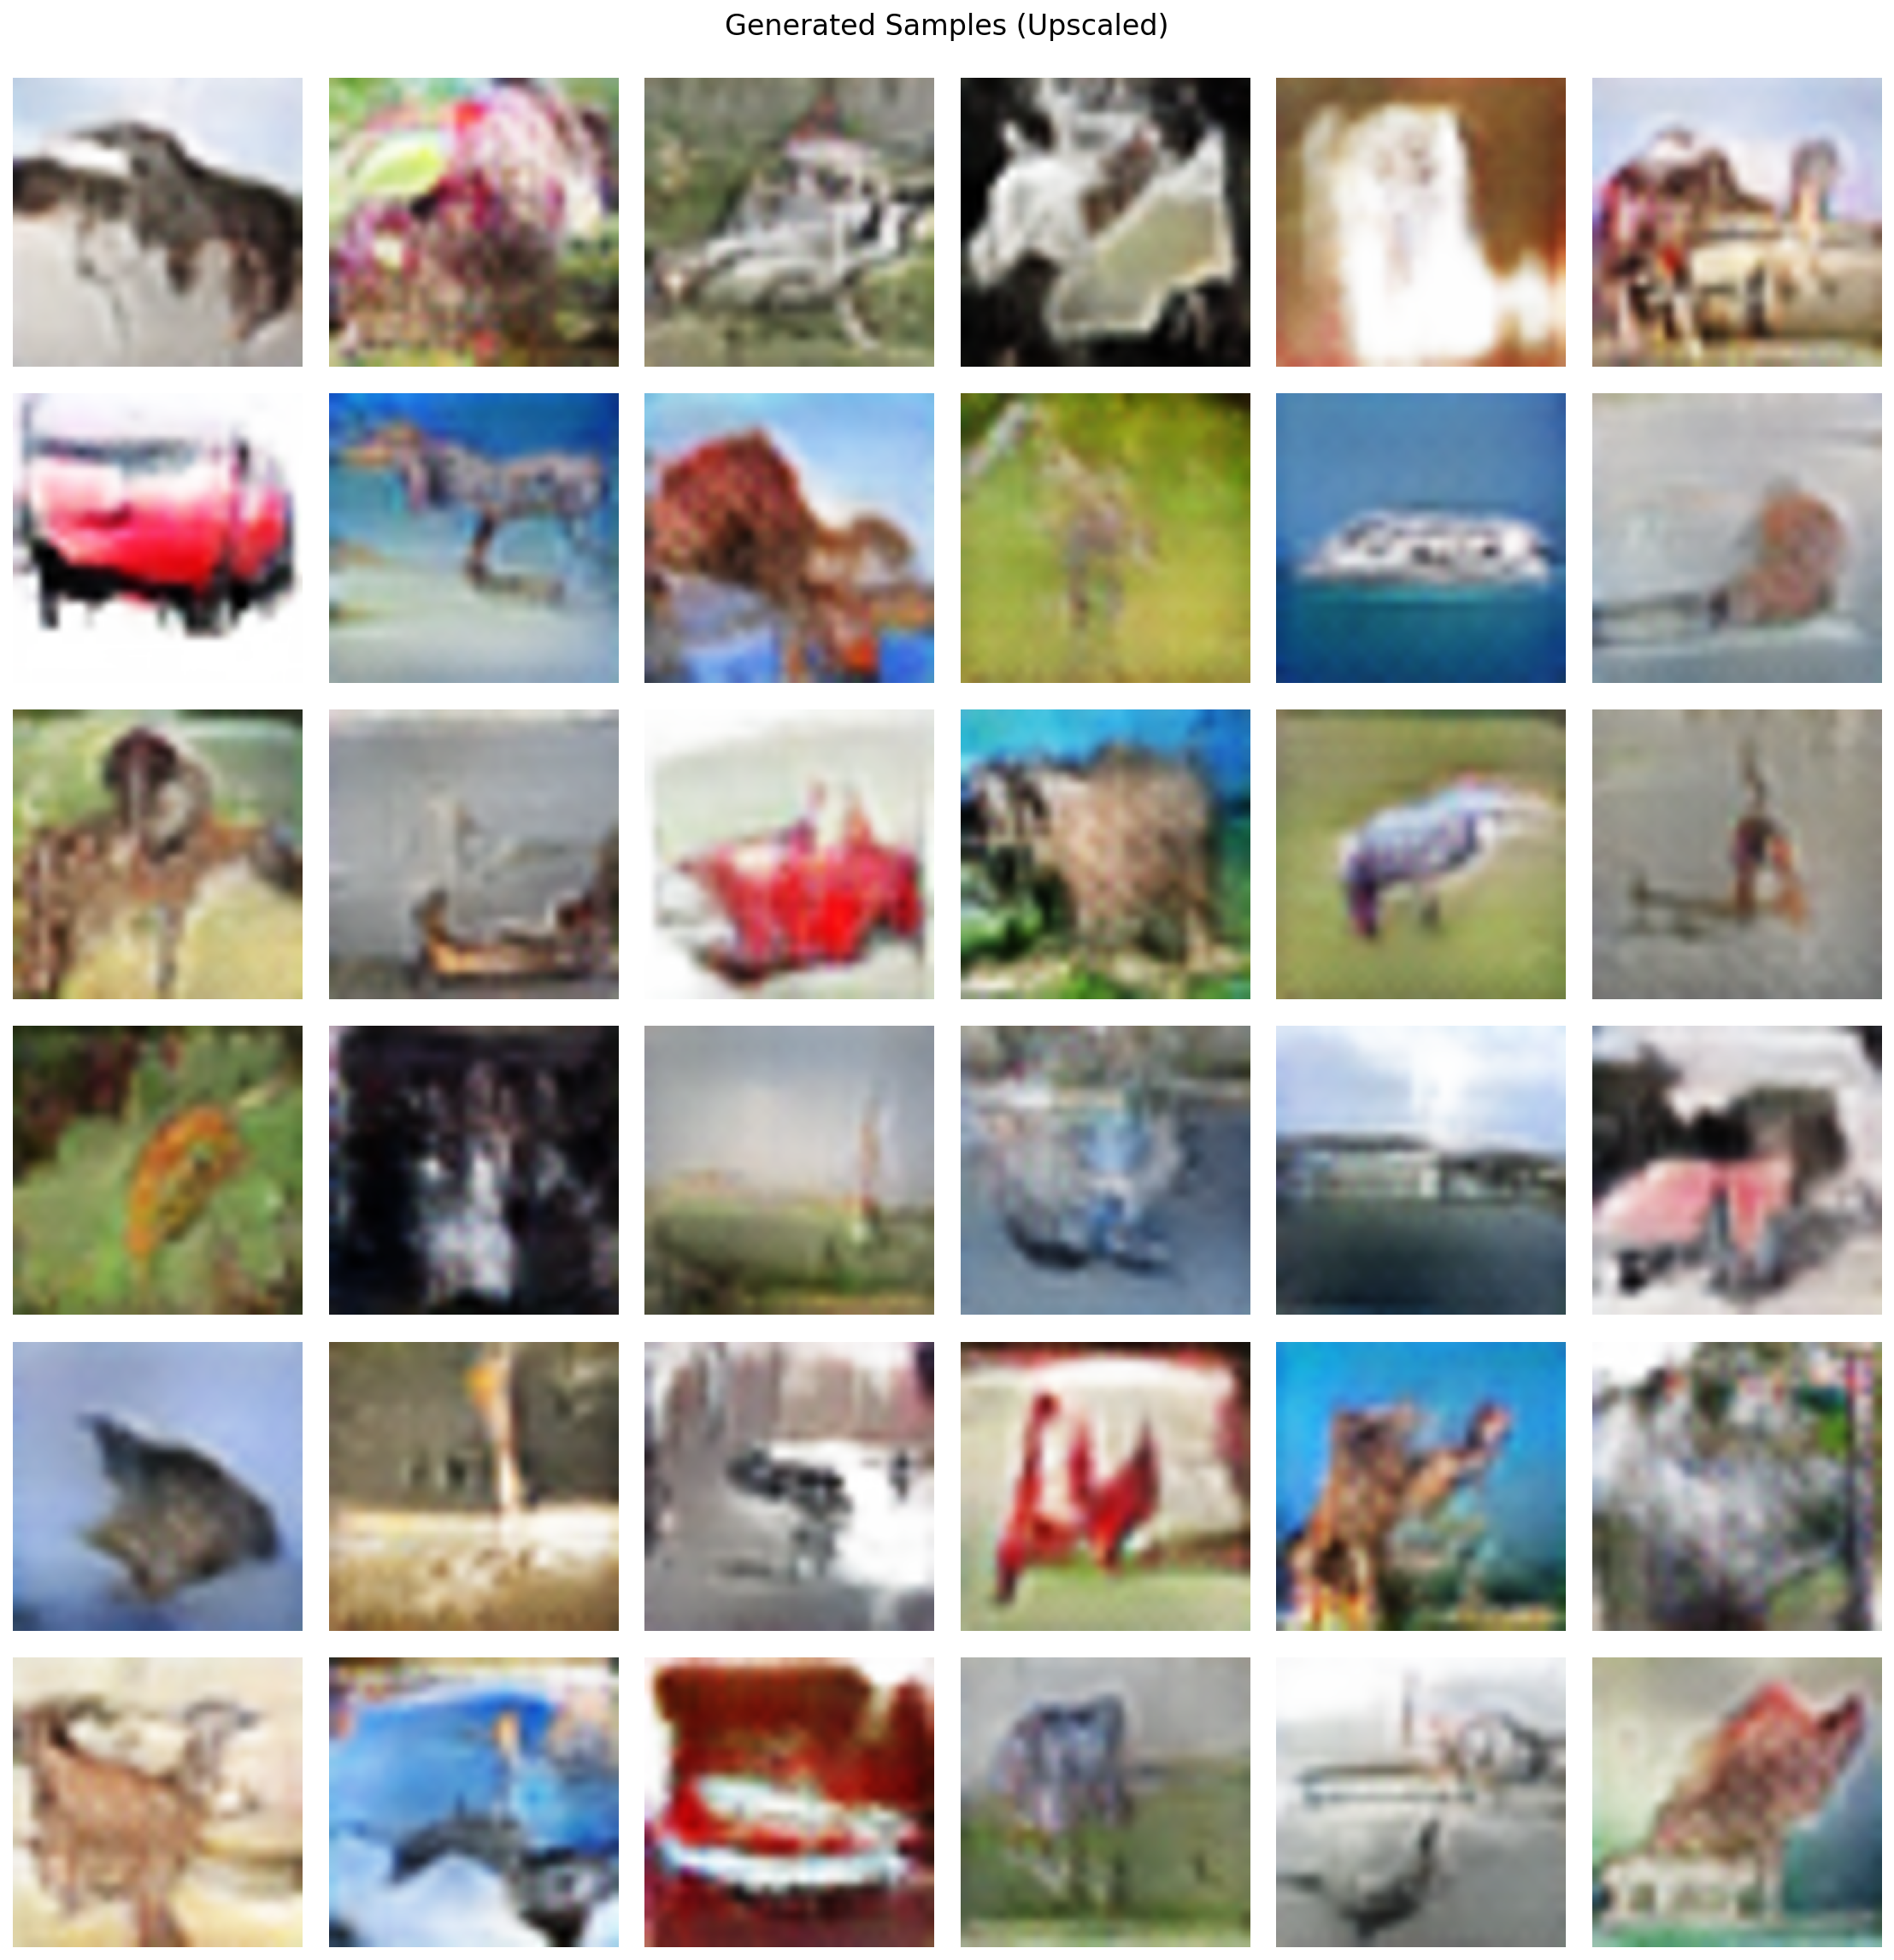


Plotting training curves...


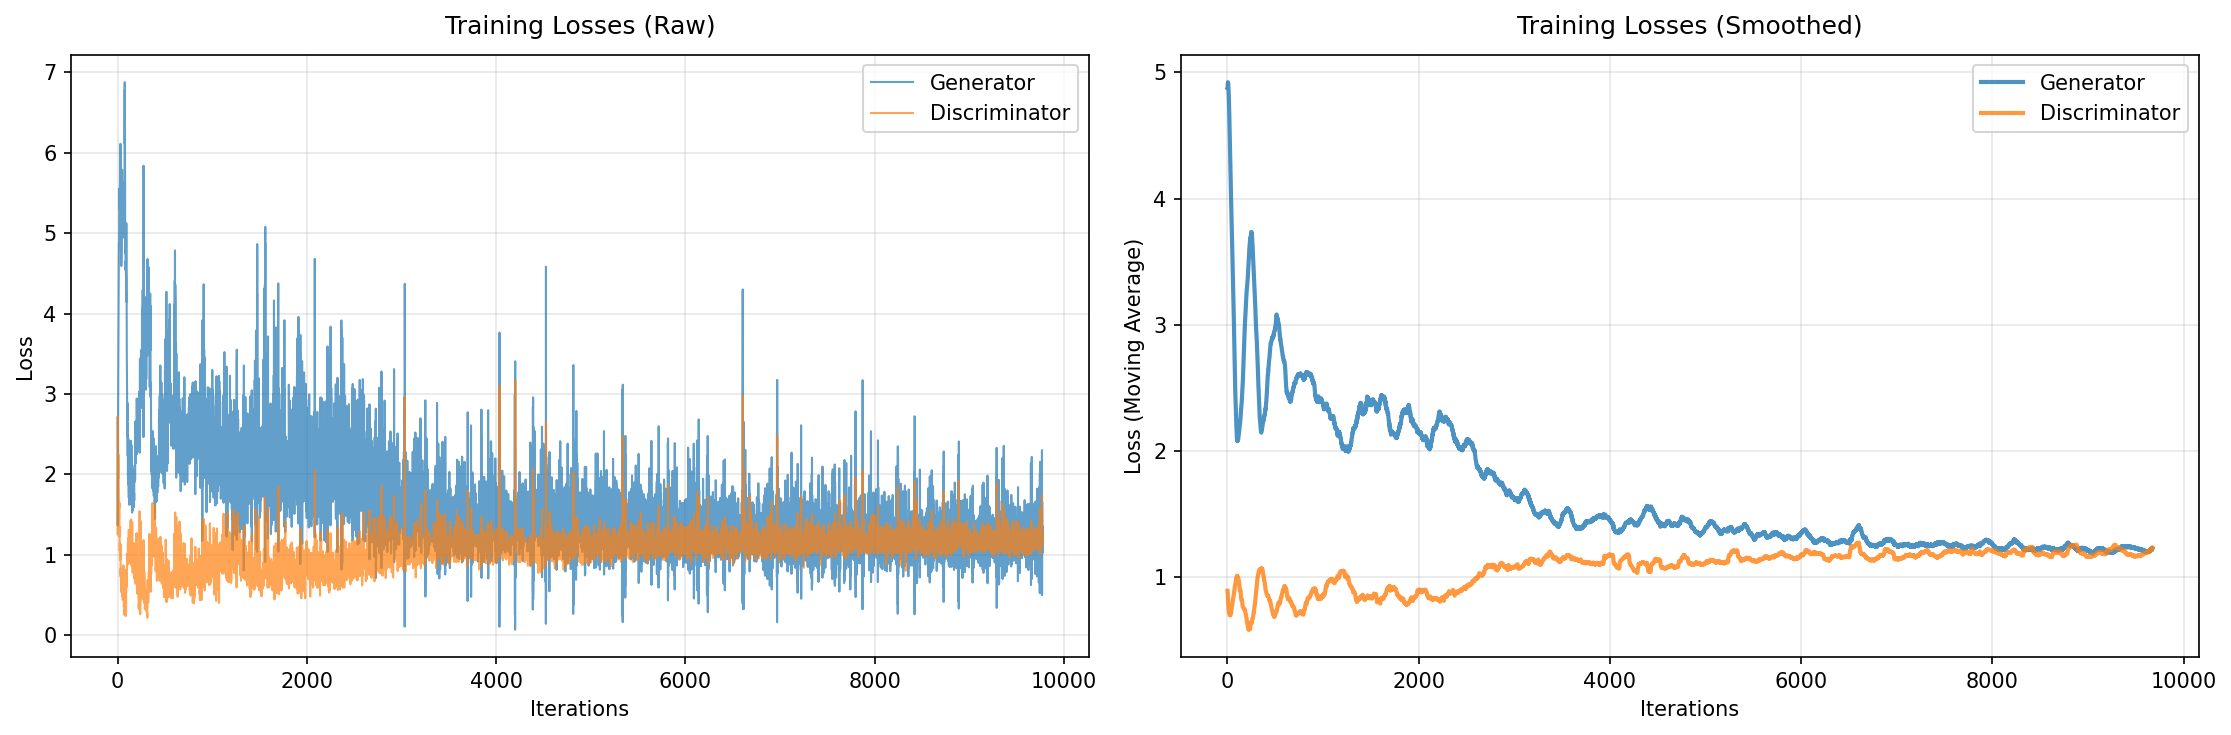


Generating latent space interpolation...


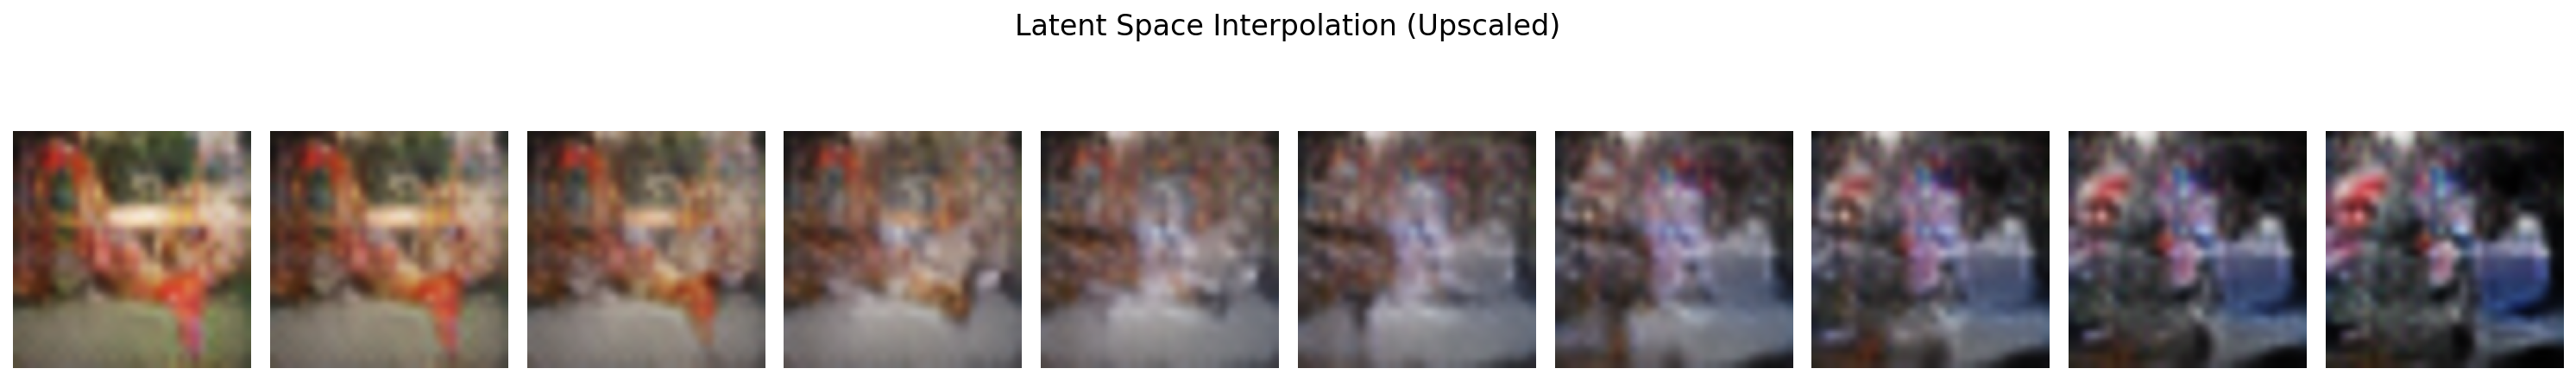


Saving upscaled samples to 'dcgan_samples_upscaled.png'...

Generating individual high-res samples...

Showing upscaling comparison...


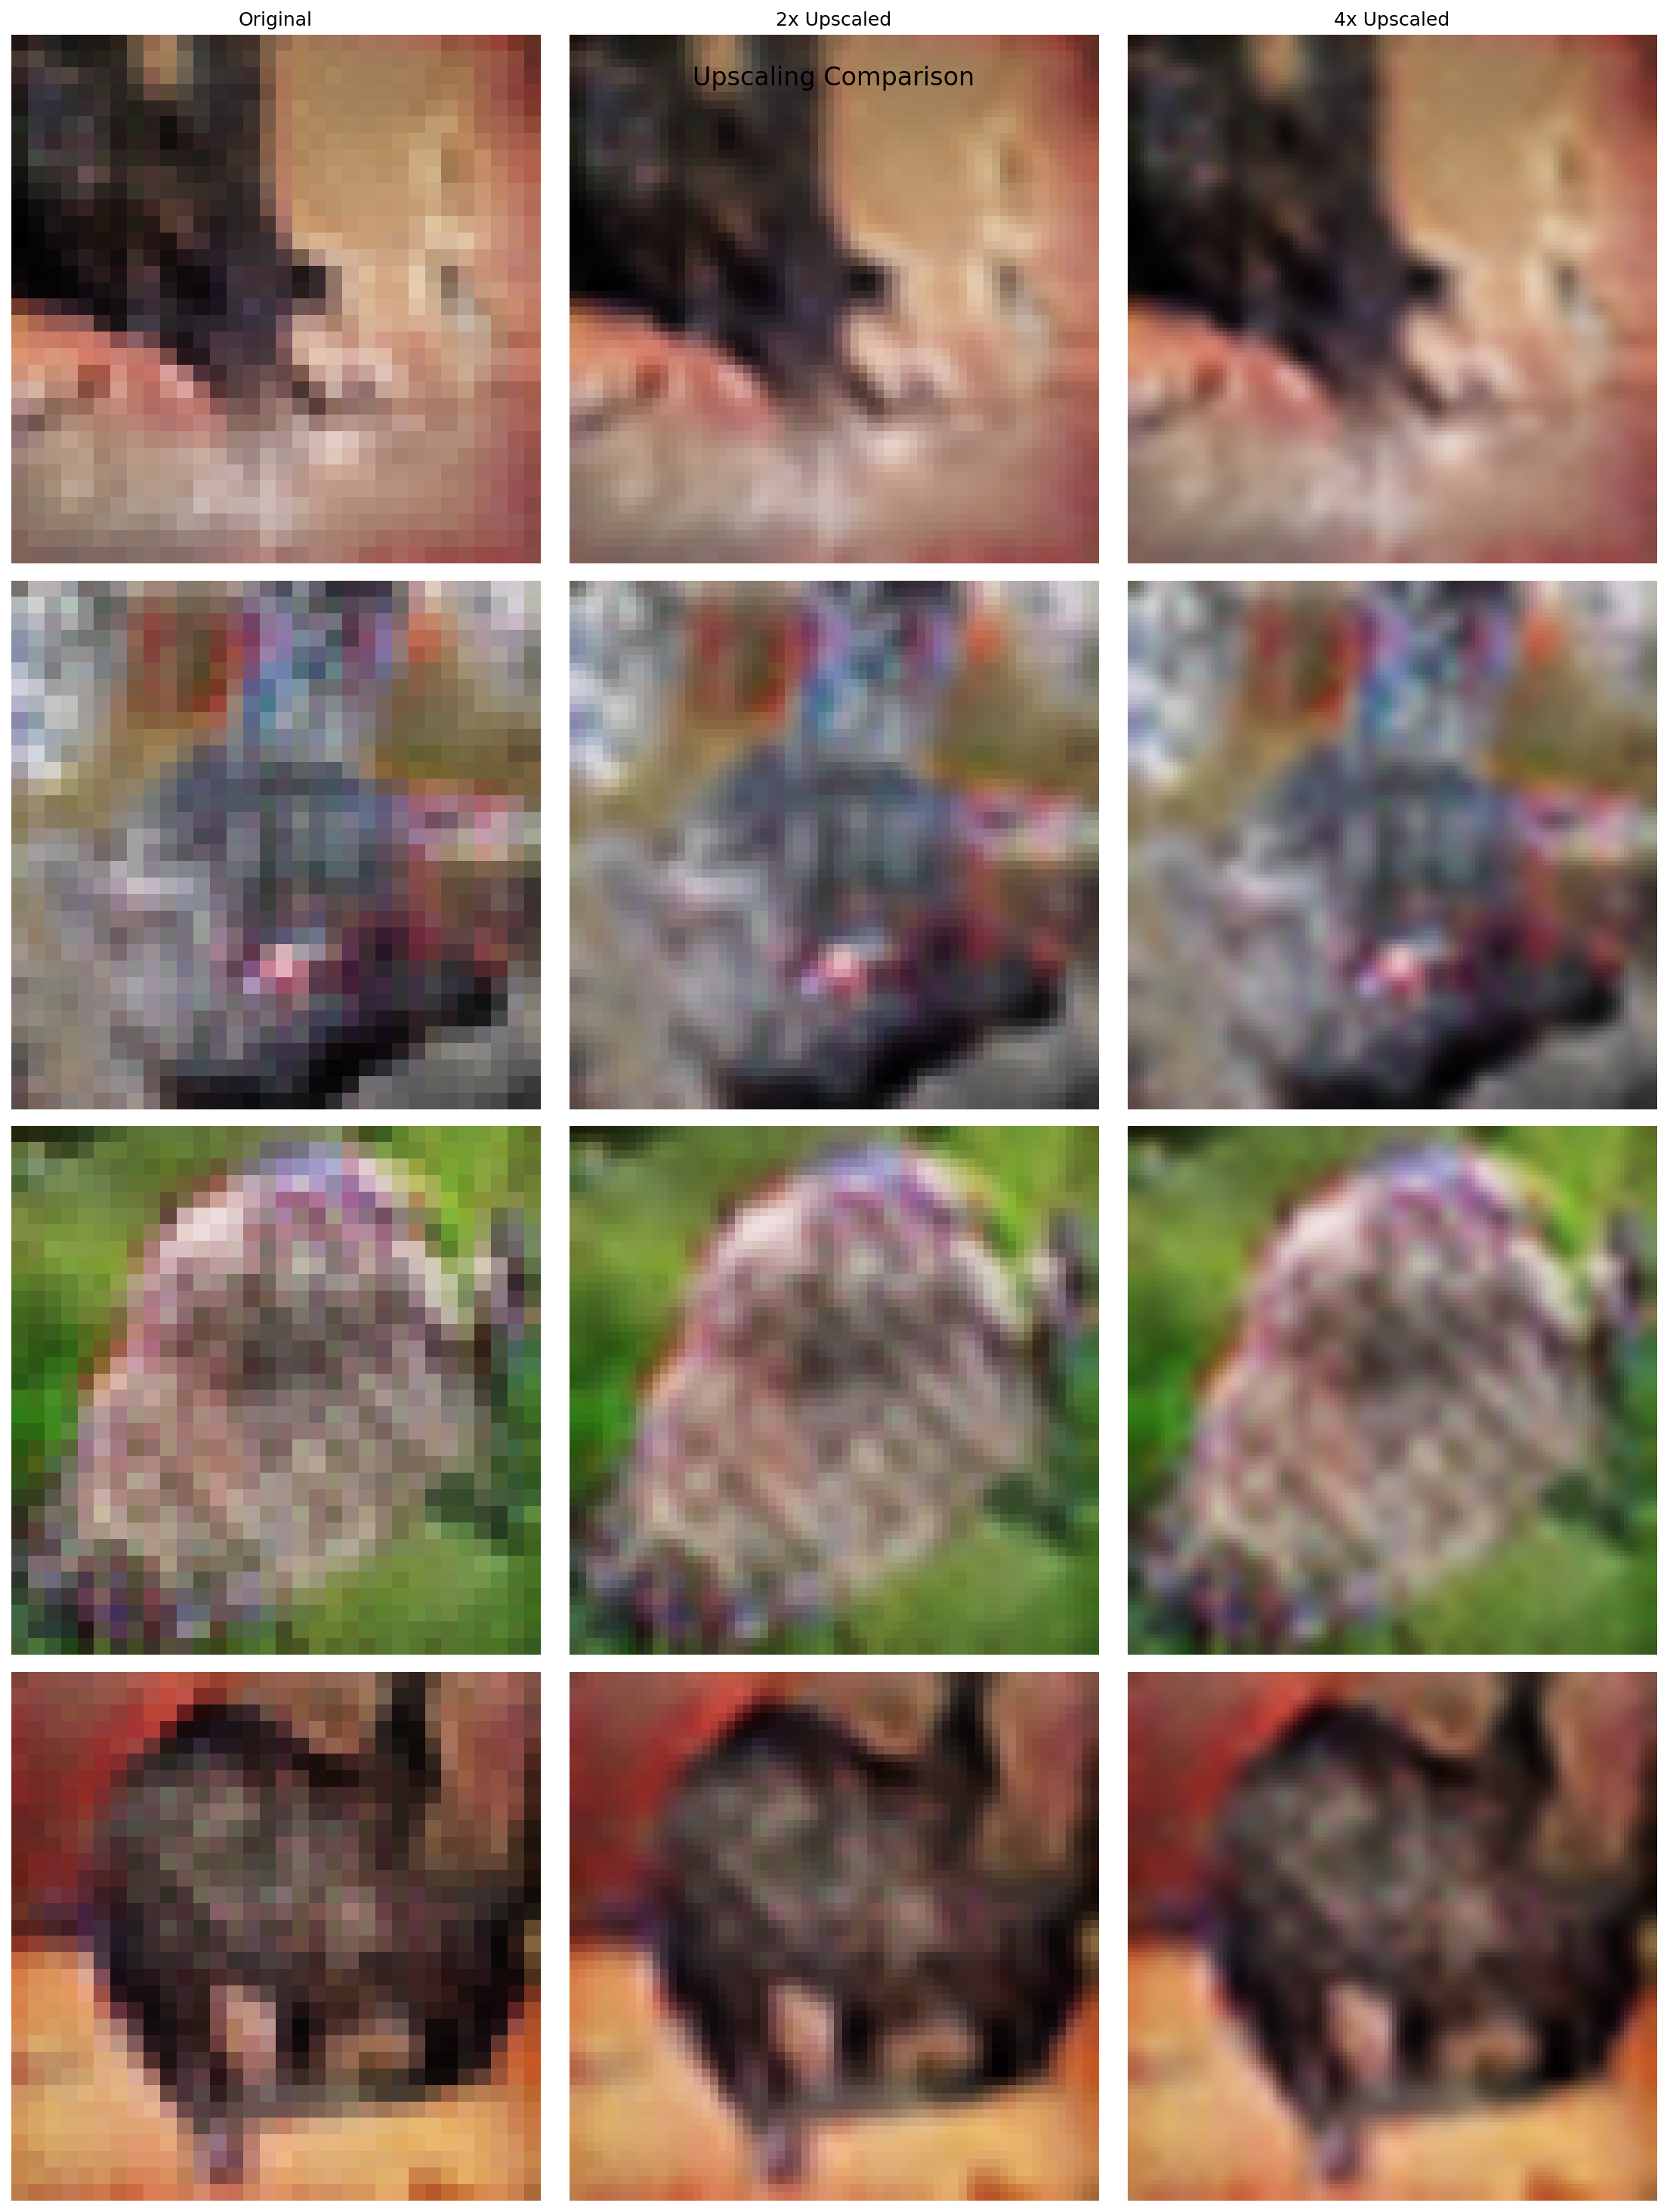

In [15]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import functional as TF
from PIL import Image
import torch.nn.functional as F

def upscale_image(tensor_image, scale_factor=4):
    """
    Upscale a tensor image using high-quality interpolation
    tensor_image: CxHxW tensor in range [0,1]
    """
    # Convert to BHWC format for F.interpolate
    if len(tensor_image.shape) == 3:
        tensor_image = tensor_image.unsqueeze(0)
    
    # Upscale using bicubic interpolation with antialiasing
    upscaled = F.interpolate(
        tensor_image,
        scale_factor=scale_factor,
        mode='bicubic',
        align_corners=False,
        antialias=True
    )
    
    # Ensure values stay in [0,1]
    return torch.clamp(upscaled, 0, 1)

def plot_current_state(model, num_images=36, upscale_factor=4):
    """Plot a grid of generated images with upscaling"""
    model.eval()
    with torch.no_grad():
        # Generate fixed noise samples
        z = torch.randn(num_images, model.hparams.latent_dim, device=model.device)
        # Generate images
        samples = model(z)
        # Move to CPU and convert to numpy
        samples = ((samples * 0.5) + 0.5).cpu()  # Scale from [-1,1] to [0,1]
        
        # Upscale each image
        samples_upscaled = torch.stack([
            upscale_image(img, upscale_factor)[0] for img in samples
        ])
    
    # Create a figure with higher DPI for better quality
    plt.figure(figsize=(15, 15), dpi=150)
    for i in range(num_images):
        plt.subplot(6, 6, i+1)
        plt.imshow(samples_upscaled[i].permute(1, 2, 0))
        plt.axis('off')
    plt.tight_layout(pad=1.5)
    plt.suptitle('Generated Samples (Upscaled)', y=1.02, fontsize=16)
    plt.show()

def plot_training_curves(model):
    """Plot discriminator and generator losses with improved styling"""
    plt.figure(figsize=(15, 5), dpi=150)
    
    # Raw losses
    plt.subplot(1, 2, 1)
    plt.plot(model.g_losses, label='Generator', alpha=0.7, linewidth=1)
    plt.plot(model.d_losses, label='Discriminator', alpha=0.7, linewidth=1)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Training Losses (Raw)', pad=10)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Smoothed losses
    window_size = 100
    g_losses_smooth = np.convolve(model.g_losses, 
                                 np.ones(window_size)/window_size, 
                                 mode='valid')
    d_losses_smooth = np.convolve(model.d_losses, 
                                 np.ones(window_size)/window_size, 
                                 mode='valid')
    
    plt.subplot(1, 2, 2)
    plt.plot(g_losses_smooth, label='Generator', alpha=0.8, linewidth=2)
    plt.plot(d_losses_smooth, label='Discriminator', alpha=0.8, linewidth=2)
    plt.xlabel('Iterations')
    plt.ylabel('Loss (Moving Average)')
    plt.title('Training Losses (Smoothed)', pad=10)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def interpolate_latent_space(model, num_steps=10, upscale_factor=4):
    """Generate interpolation between two random points in latent space with upscaling"""
    model.eval()
    with torch.no_grad():
        # Generate two random points in latent space
        z1 = torch.randn(1, model.hparams.latent_dim, device=model.device)
        z2 = torch.randn(1, model.hparams.latent_dim, device=model.device)
        
        # Create interpolation steps
        alphas = torch.linspace(0, 1, num_steps)
        z_interp = torch.stack([(1-a)*z1 + a*z2 for a in alphas]).squeeze()
        
        # Generate images
        samples = model(z_interp)
        # Scale from [-1,1] to [0,1]
        samples = ((samples * 0.5) + 0.5).cpu()
        
        # Upscale images
        samples_upscaled = torch.stack([
            upscale_image(img, upscale_factor)[0] for img in samples
        ])
    
    # Plot interpolation
    plt.figure(figsize=(20, 3), dpi=150)
    for i in range(num_steps):
        plt.subplot(1, num_steps, i+1)
        plt.imshow(samples_upscaled[i].permute(1, 2, 0))
        plt.axis('off')
    plt.suptitle('Latent Space Interpolation (Upscaled)', y=1.05, fontsize=16)
    plt.tight_layout()
    plt.show()

def save_samples(model, filename, num_images=36, upscale_factor=4):
    """Save a grid of generated images with upscaling"""
    model.eval()
    with torch.no_grad():
        # Generate images
        z = torch.randn(num_images, model.hparams.latent_dim, device=model.device)
        samples = model(z)
        samples = ((samples * 0.5) + 0.5).cpu()
        
        # Upscale each image
        samples_upscaled = torch.stack([
            upscale_image(img, upscale_factor)[0] for img in samples
        ])
        
        # Create grid
        grid = torchvision.utils.make_grid(samples_upscaled, nrow=6, padding=2, normalize=False)
        
        # Convert to PIL Image for high-quality saving
        grid_np = grid.permute(1, 2, 0).numpy()
        grid_pil = Image.fromarray((grid_np * 255).astype('uint8'))
        grid_pil.save(filename, quality=95, subsampling=0)

def generate_and_save_individual(model, num_images=5, upscale_factor=8, base_filename="generated"):
    """Generate and save individual high-resolution images"""
    model.eval()
    with torch.no_grad():
        for i in range(num_images):
            # Generate single image
            z = torch.randn(1, model.hparams.latent_dim, device=model.device)
            sample = model(z)
            sample = ((sample * 0.5) + 0.5).cpu()
            
            # Upscale
            upscaled = upscale_image(sample[0], upscale_factor)[0]
            
            # Convert to PIL Image and save
            img_np = upscaled.permute(1, 2, 0).numpy()
            img_pil = Image.fromarray((img_np * 255).astype('uint8'))
            img_pil.save(f"{base_filename}_{i+1}.png", quality=95, subsampling=0)

def show_upscaling_comparison(model, num_images=4):
    """Show comparison between original and upscaled images"""
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_images, model.hparams.latent_dim, device=model.device)
        samples = model(z)
        samples = ((samples * 0.5) + 0.5).cpu()
        
        # Create upscaled versions
        samples_upscaled_2x = torch.stack([upscale_image(img, 2)[0] for img in samples])
        samples_upscaled_4x = torch.stack([upscale_image(img, 4)[0] for img in samples])
        
        plt.figure(figsize=(15, 5*num_images), dpi=150)
        for i in range(num_images):
            # Original
            plt.subplot(num_images, 3, i*3 + 1)
            plt.imshow(samples[i].permute(1, 2, 0))
            if i == 0: plt.title('Original')
            plt.axis('off')
            
            # 2x upscaled
            plt.subplot(num_images, 3, i*3 + 2)
            plt.imshow(samples_upscaled_2x[i].permute(1, 2, 0))
            if i == 0: plt.title('2x Upscaled')
            plt.axis('off')
            
            # 4x upscaled
            plt.subplot(num_images, 3, i*3 + 3)
            plt.imshow(samples_upscaled_4x[i].permute(1, 2, 0))
            if i == 0: plt.title('4x Upscaled')
            plt.axis('off')
        
        plt.suptitle('Upscaling Comparison', y=0.95, fontsize=16)
        plt.tight_layout()
        plt.show()

# Test the model
if __name__ == "__main__":
    # Train model if not already trained
    try:
        model
    except NameError:
        model = train_dcgan()
    
    print("Plotting current generated samples (upscaled)...")
    plot_current_state(model)
    
    print("\nPlotting training curves...")
    plot_training_curves(model)
    
    print("\nGenerating latent space interpolation...")
    interpolate_latent_space(model)
    
    print("\nSaving upscaled samples to 'dcgan_samples_upscaled.png'...")
    save_samples(model, 'dcgan_samples_upscaled.png')
    
    print("\nGenerating individual high-res samples...")
    generate_and_save_individual(model)
    
    print("\nShowing upscaling comparison...")
    show_upscaling_comparison(model)